# Binary Bandit with stationary rewards 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
import random
# --- Bandit ---
class BinaryBandit(object):
  def __init__(self):
    # N = number of arms
    self.N = 2
  def actions(self):
    result = []
    for i in range(0,self.N):
      result.append(i)
    return result
  def reward1(self, action):
    p = [0.1, 0.2]
    rand = random.random()
    if rand < p[action]:
      return 1
    else:
      return 0
  def reward2(self, action):
    p = [0.9, 0.8]
    rand = random.random()
    if rand < p[action]:
      return 1
    else:
      return 0


In [5]:
myBandit = BinaryBandit()

In [6]:
def eGreedy(myBandit, epsilon, max_iteration):
  # Initialization 
  Q = [0]*myBandit.N 
  count = [0]*myBandit.N
  epsilon = epsilon
  r = 0
  R = [] #array of rewards
  R_avg = [0]*1  #average of rewards recieved till iter i
  max_iter = max_iteration
  # Incremental Implementation
  for iter in range(1,max_iter):
    if random.random() > epsilon:
      action = Q.index(max(Q)) # Exploit/ Greed
    else:
      action = random.choice(myBandit.actions()) # Explore
    r = myBandit.reward1(action)
    R.append(r)
    count[action] = count[action]+1
    Q[action] = Q[action]+(r - Q[action])/count[action]
    R_avg.append(R_avg[iter-1] + (r-R_avg[iter-1])/iter)

  return Q, R_avg, R

In [7]:
Q , R_avg , R = eGreedy(myBandit, 0.2,10000)
print(Q)
#print(R)

#print(R_avg)


[0.10124164278892064, 0.19906166219839155]


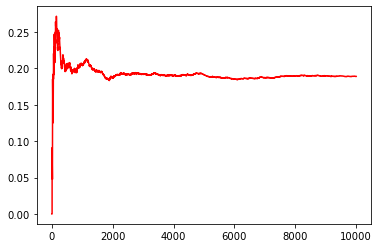

In [8]:
plt.plot(R_avg,color= 'red')

#it can be seen in the graph that -> for 10000 iterations, 

#here we are given weights, so the weighted average corresponds to average.
#As the average reward is 0.5 for both the actions, this case the choice of action doesn’t matter,
#as we expect – on average – to receive the same reward in the long run.

## **10 - arm bandit**

### Develop a 10-armed bandit in which all ten mean-rewards start out equal and then take independent random walks (by adding a normally distributed increment with mean zero and standard deviation 0.01 to all mean-rewards on each time step). 

### The 10-armed bandit that you developed (bandit_nonstat) is difficult to crack with a standard epsilon-greedy algorithm since the rewards are non-stationary.  We did discuss how to track non-stationary rewards in class.  Write a modified epsilon-greedy agent and show whether it is able to latch onto correct actions or not.  (Try at least 10000 time steps before commenting on results)


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# A class for  all the parameters of the algorithm
class Params:
    def __init__(self):
        # number of bandit's arms
        self.k = 10

        # mean and standard deviation random walk of q_star
        self.mu, self.sigma = 0, 0.01

        # number of k-armed bandit problems
        self.m = None

        # step size
        self.alpha = 0.1

        # step size possible values
        self.alphas = [2 ** x for x in range(-5, 2)]

        # epsilon-greedy parameter epsilon
        self.epsilon = 0.1

        # epsilon-greedy parameter epsilon possible values
        self.epsilons = [2 ** x for x in range(-7, -1)]

        # UCB parameter c possible values
        self.cs = [2 ** x for x in range(-4, 3)]

        # greedy with optimistic initialization possible initialization values
        self.initializations = [2 ** x for x in range(-2, 3)]

        # steps of a run
        self.steps = None

        # number of last steps over the average is computed
        self.last_steps_eval = 10000

        # names of the algorithms used to solve the k-armed bandit problem
        self.bandit_types = None


In [7]:
# A class for an algorithm for solving the k-armed bandit problem
class Bandit:
    def __init__(self, bandit_type, k, epsilon, m, alpha, c=None, initialization=None):
        
       
        # Set up the parameters
        self.bandit_type = bandit_type #algorithm used to solve the k-armed bandit problem
        self.k = k #number of arms of a bandit
        self.epsilon = epsilon
        self.m = m  #number of bandits
        self.alpha = alpha  #step size
        self.c = c
        self.initialization = initialization

        # Table q_star, real reward mean for each action of each bandit
        self.q_star = np.zeros((self.m, self.k))

        # Table N, used for sample-average method
        self.N = np.zeros((self.m, self.k))

        # Time variable, used for UCB method
        self.time = 0

        # Table Q, estimate reward mean for each action of each bandit (zero if there is no initialization)
        if initialization is None:
            self.Q = np.zeros((self.m, self.k))
        else:
            self.Q = np.full((self.m, self.k), initialization)

    def step(self):
        """
        Choose action for each bandit, observe results and update appropriate tables
        :returs the actions taken and reward obtained
        """
        # Sample average action selection algorithm
        if self.bandit_type == 'sample_average':
            # Choose the action to take for each bandit
            A = [np.argmax(row) if np.random.binomial(1, self.epsilon) == 0 else int(np.random.uniform(0, self.k)) for
                 row in self.Q[:, ]]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update N and Q tables
            self.N = np.reshape([self.N[i, :] + Bandit.one_hot(value, self.k) for i, value in enumerate(A)],
                                (self.m, self.k))
            self.Q = np.reshape([self.Q[i, :] + (1 / self.N[i, value]) * (R[i] - self.Q[i, value]) *
                                 Bandit.one_hot(value, self.k) for i, value in enumerate(A)], (self.m, self.k))

        # Sample average action selection algorithm with constant step size, with zero or optimistic initialization
        elif self.bandit_type == 'constant_step_size' or self.bandit_type == 'optimistic_init':
            # Choose the action to take for each bandit
            A = [np.argmax(row) if np.random.binomial(1, self.epsilon) == 0 else int(np.random.uniform(0, self.k)) for
                 row in self.Q[:, ]]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update Q table
            self.Q = np.reshape([self.Q[i, :] + self.alpha * (R[i] - self.Q[i, value]) * Bandit.one_hot(value, self.k)
                                 for i, value in enumerate(A)], (self.m, self.k))

        # Gradient bandit algorithm
        elif self.bandit_type == 'gradient':
            A_probability = [np.exp(row)/np.sum(np.exp(row)) for row in self.Q[:, ]]

            # Choose the action to take for each bandit
            A = [np.random.choice(np.arange(self.k), p=p) for p in A_probability]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update Q table
            self.Q = np.reshape([self.Q[i, :] + self.alpha * R[i] * (Bandit.one_hot(value, self.k) - A_probability[i])
                                 for i, value in enumerate(A)], (self.m, self.k))

        # Upper-Confidence-Bound action selection algorithm
        elif self.bandit_type == 'ucb':
            # Choose the action to take for each bandit
            A = [np.argmax(row + self.c * np.sqrt(np.log(self.time + 1) / (n + 1))) if
                 np.random.binomial(1,self.epsilon) == 0 else int(np.random.uniform(0, self.k)) for row, n in
                 zip(self.Q[:, ], self.N[:, ])]

            # Observe rewards
            R = [np.random.normal(self.q_star[i, value], 1) for i, value in enumerate(A)]

            # Update time value
            self.time += 1

            # Update N and Q tables
            self.N = np.reshape([self.N[i, :] + Bandit.one_hot(value, self.k) for i, value in enumerate(A)],
                                (self.m, self.k))
            self.Q = np.reshape([self.Q[i, :] + (1 / self.N[i, value]) * (R[i] - self.Q[i, value]) *
                                 Bandit.one_hot(value, self.k) for i, value in enumerate(A)], (self.m, self.k))

        return A, R
    
    @staticmethod
    def one_hot(position, length):
        
       # position: position of the '1' value
        #length: length of the array
        
        assert length > position, 'position {:d} greater than or equal to length {:d}'.format(position, length)
        oh = np.zeros(length)
        oh[position] = 1
        return oh
    
    #

In [8]:
def show_results(bandit_types, ARs, POAs):
    
    
    # bandit_types: names of the algorithms used to solve the k-armed bandit problem
    # ARs: average reward value, for each algorithm and for each step
    # POAs: percentage of optimal action chosen value, for each algorithm and for each step
    
    for bandit_type, AR, POA in zip(bandit_types, ARs, POAs):
        plt.figure(0)
        plt.plot(AR, label=bandit_type)
        plt.legend(loc='best')
        plt.xlabel('Steps')
        plt.ylabel('Average reward')

        plt.figure(1)
        plt.plot(POA, label=bandit_type)
        plt.legend(loc='best')
        plt.xlabel('Steps')
        plt.ylabel('% Optimal action')
        
def solution():
    # Set up parameters
    params = Params()

    params.m = 2000
    params.steps = 10000
    params.bandit_types = ['sample_average', 'constant_step_size']

    ARs = []
    POAs = []

    for bandit_type in params.bandit_types:
        print('Method', bandit_type)

        # Average Reward
        AR = []

        # Percentage of Optimal Action
        POA = []

        # Set up the algorithm
        bandit = Bandit(bandit_type, params.k, params.epsilon, params.m, params.alpha)

        for _ in range(params.steps):
            # Take a step
            A, R = bandit.step()

            # Collect rewards and compute the percentage of optimal values
            AR.append(np.average(R))
            POA.append(np.average([100 if value == np.argmax(bandit.q_star[i, :]) else 0 for i, value in enumerate(A)]))

            # Change the true value of every arm of every bandit
            bandit.q_star += np.random.normal(params.mu, params.sigma, (params.m, params.k))

        ARs.append(AR)
        POAs.append(POA)

    # Show results
    show_results(params.bandit_types, ARs, POAs)

In [ ]:
solution()
plt.show()

Method sample_average
